This code is designed for data collect from Nikon JOBS, name the sample as "Rep_D6_087.nd2", have 3 channel, DAPI, GFP, Dsred in z stacks.

In [1]:
# =============================================================================
# Cell 1: Import Libraries and Check CUDA Availability
# =============================================================================
import os
import re
import gc
import torch
import numpy as np
import tifffile
import pandas as pd
from nd2reader import ND2Reader
from tqdm import tqdm
from cellpose import models

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")
else:
    print("No GPU detected or CUDA is not available.")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4090


In [2]:
# check the iamge file for example
import os
from nd2reader import ND2Reader

def check_nd2_info(nd2_path):
    """
    Opens an ND2 file and prints image information including:
      - Detected axes
      - Image dimensions (shape)
      - Channel names (if available)
      - Additional metadata
    """
    try:
        with ND2Reader(nd2_path) as img:
            print(f"\nProcessing ND2 File: {os.path.basename(nd2_path)}")
            print("Detected Axes:", img.axes)
            print("Image Shape:", img.shape)
            
            channels = img.metadata.get('channels')
            if channels:
                print("Channels:", channels)
            else:
                print("No channel information available in metadata.")
            
            # Print additional metadata keys and values
            print("Additional Metadata:")
            for key, value in img.metadata.items():
                print(f"  {key}: {value}")
    except Exception as e:
        print(f"Error processing {nd2_path}: {e}")

# Specify the ND2 file you want to inspect
nd2_file_path = r"A:\_Ongoing\20250221_ActRep_rename\Act_A1_001.nd2"
check_nd2_info(nd2_file_path)



Processing ND2 File: Act_A1_001.nd2
Detected Axes: ['x', 'y', 'c', 't', 'z']
Image Shape: (7, 900, 600)
Channels: ['40x 405', '40x 561', '40x 488']
Additional Metadata:
  height: 900
  width: 600
  date: 2025-02-22 14:26:47
  fields_of_view: [0]
  frames: [0]
  z_levels: range(0, 7)
  z_coordinates: [4960.219999999981, 4960.8199999999815, 4961.399999999981, 4961.979999999981, 4962.619999999982, 4963.199999999982, 4963.8199999999815]
  total_images_per_channel: 7
  channels: ['40x 405', '40x 561', '40x 488']
  pixel_microns: 0.273400847258364
  num_frames: 1
  experiment: {'description': '', 'loops': []}
  events: []


In [3]:
# =============================================================================
# Configuration: Define Channel Names (Edit these if channel names change)
# =============================================================================
CHANNEL_DAPI  = '40x 405'   # Used for cell mask generation
CHANNEL_DsRed = '40x 561'
CHANNEL_GFP   = '40x 488'

In [4]:
# =============================================================================
# Function: Convert ND2 to TIFF for a Given Channel
# =============================================================================
def convert_nd2_to_tiff_channel(nd2_path, tiff_output_dir, channel_name):
    """
    Converts an ND2 file to TIFF files by performing a maximum intensity projection
    over the z-axis for the specified channel.
    
    Parameters:
      nd2_path: Path to the input ND2 file.
      tiff_output_dir: Directory where the TIFF files will be saved.
      channel_name: Name of the channel to extract.
    """
    try:
        with ND2Reader(nd2_path) as img:
            print(f"\nProcessing ND2 file: {os.path.basename(nd2_path)}")
            print("Detected Axes:", img.axes)
            print("Detected Shape:", img.shape)
            
            channels = img.metadata.get('channels')
            if channels is None:
                raise ValueError("No channel information found in ND2 metadata.")
            print("Channels in file:", channels)
            
            if channel_name in channels:
                channel_index = channels.index(channel_name)
                print(f"Using channel '{channel_name}' at index {channel_index}.")
            else:
                print(f"Channel '{channel_name}' not found in {nd2_path}. Skipping conversion for this channel.")
                return
            
            img.default_coords['c'] = channel_index

            # Setup iteration: if a time axis exists, iterate over it and bundle z,y,x.
            if 't' in img.axes and img.sizes.get('t', 1) > 1:
                img.iter_axes = 't'
                img.bundle_axes = 'zyx'
            else:
                img.iter_axes = ''
                img.bundle_axes = 'zyx'
                
            # For each time frame (or single image), perform a max projection along z.
            for idx, frame in enumerate(img):
                max_proj = np.max(frame, axis=0)
                base_name = os.path.splitext(os.path.basename(nd2_path))[0]
                if 't' in img.axes and img.sizes.get('t', 1) > 1:
                    tiff_filename = f"{base_name}_t{idx}.tiff"
                else:
                    tiff_filename = f"{base_name}.tiff"
                tiff_path = os.path.join(tiff_output_dir, tiff_filename)
                tifffile.imwrite(tiff_path, max_proj)
                print(f"Saved TIFF: {tiff_path}")
    except Exception as e:
        print(f"Error converting {nd2_path} for channel {channel_name} to TIFF: {e}")

# =============================================================================
# Function: Generate Cell Mask Using Cellpose (Using DAPI Channel)
# =============================================================================
def generate_cellmask(tiff_path, mask_path, model):
    """
    Generates a cell mask from the given TIFF image (typically DAPI) using Cellpose and saves the mask.
    
    Parameters:
      tiff_path: Path to the TIFF image used for mask generation.
      mask_path: Output path for the generated mask TIFF.
      model: An instance of the Cellpose model.
    """
    try:
        img = tifffile.imread(tiff_path)
        # If the image is 3D (a stack), average over the first axis to obtain a 2D image.
        if img.ndim == 3:
            img = img.mean(axis=0)
        elif img.ndim > 3:
            raise ValueError(f"Unexpected number of dimensions ({img.ndim}) in image: {tiff_path}")

        img_min, img_max = np.min(img), np.max(img)
        dynamic_range = img_max - img_min
        if dynamic_range == 0:
            print(f"Warning: Image {tiff_path} has zero dynamic range. Skipping mask generation.")
            return
        
        img = img.astype(np.float32)
        img = (img - img_min) / dynamic_range

        if not np.isfinite(img).all():
            print(f"Warning: Image {tiff_path} contains non-finite values after normalization. Skipping.")
            return

        # Run Cellpose (adjust parameters such as diameter if needed)
        masks, flows, styles, diams = model.eval(
            img,
            diameter=None,
            flow_threshold=0.4,
            cellprob_threshold=0.0,
            channels=[0, 0]
        )
        tifffile.imwrite(mask_path, masks.astype(np.uint16))
        print(f"Saved cell mask: {mask_path}")
    except Exception as e:
        print(f"Error generating mask for {tiff_path}: {e}")
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# =============================================================================
# Function: Calculate Cell-Level Intensities
# =============================================================================
def calculate_intensities(tiff_files, tiff_dirs, mask_dir, output_csv):
    """
    For each TIFF file, calculates the average intensity per cell (using the generated mask)
    for both GFP and DsRed channels and saves the data to a CSV file.
    
    Parameters:
      tiff_files: List of TIFF filenames (assumed to be identical for GFP and DsRed channels).
      tiff_dirs: Dictionary with keys "GFP" and "DsRed" mapping to their respective TIFF directories.
      mask_dir: Directory where the cell masks are stored.
      output_csv: Path for the output CSV file.
    """
    data = []
    for tiff_file in tqdm(tiff_files, desc="Calculating Intensities"):
        gfp_path = os.path.join(tiff_dirs["GFP"], tiff_file)
        dsred_path = os.path.join(tiff_dirs["DsRed"], tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        if not os.path.exists(gfp_path):
            print(f"GFP image {gfp_path} not found. Skipping.")
            continue
        if not os.path.exists(dsred_path):
            print(f"DsRed image {dsred_path} not found. Skipping.")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask image {mask_path} not found. Skipping.")
            continue
        
        gfp_img = tifffile.imread(gfp_path)
        dsred_img = tifffile.imread(dsred_path)
        mask_img = tifffile.imread(mask_path)
        
        mask_indices = np.unique(mask_img)
        mask_indices = mask_indices[mask_indices != 0]  # Exclude background
        
        for idx in mask_indices:
            cell_mask = (mask_img == idx)
            avg_gfp = np.mean(gfp_img[cell_mask])
            avg_dsred = np.mean(dsred_img[cell_mask])
            data.append({
                "File Name": tiff_file,
                "Mask Index": idx,
                "Average GFP Intensity": avg_gfp,
                "Average DsRed Intensity": avg_dsred
            })
    
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Cell-level intensity data saved to {output_csv}")

# =============================================================================
# Helper Function: Extract Group, Sample, and Repeat Information
# =============================================================================
def extract_info_from_filename(filename):
    """
    Extracts group (Act/Rep), sample, and repeat information from the filename.
    It first removes any time suffix (e.g., _t0) if present.
    
    Expected filename formats include:
      - 'Act_01_002.nd2'
      - 'Rep_A1_001.nd2'
    """
    base = re.sub(r'_t\d+', '', os.path.splitext(filename)[0])
    pattern = re.compile(r'^(Act|Rep)_([A-Za-z0-9]+)_(\d{3})', re.IGNORECASE)
    m = pattern.search(base)
    if m:
        return m.group(1), m.group(2), m.group(3)
    else:
        return 'Unknown', 'Unknown', 'Unknown'

# =============================================================================
# Runnable Step 1: ND2-to-TIFF Conversion for Each Channel
# =============================================================================
def run_conversion(nd2_dir, dapi_tiff_dir, dsred_tiff_dir, gfp_tiff_dir):
    """
    Converts all ND2 files in the given directory into TIFF images for the DAPI, DsRed, and GFP channels.
    
    Parameters:
      nd2_dir: Directory containing ND2 files.
      dapi_tiff_dir: Output directory for the DAPI TIFF images.
      dsred_tiff_dir: Output directory for the DsRed TIFF images.
      gfp_tiff_dir: Output directory for the GFP TIFF images.
    """
    nd2_files = [f for f in os.listdir(nd2_dir) if f.lower().endswith('.nd2')]
    if not nd2_files:
        print("No ND2 files found in", nd2_dir)
        return
    print(f"Found {len(nd2_files)} ND2 file(s) for conversion.")
    for nd2_file in nd2_files:
        nd2_path = os.path.join(nd2_dir, nd2_file)
        print(f"\n--- Processing: {nd2_file} ---")
        # Convert DAPI channel (for cell mask generation)
        convert_nd2_to_tiff_channel(nd2_path, dapi_tiff_dir, CHANNEL_DAPI)
        # Convert DsRed and GFP channels (for intensity analysis)
        convert_nd2_to_tiff_channel(nd2_path, dsred_tiff_dir, CHANNEL_DsRed)
        convert_nd2_to_tiff_channel(nd2_path, gfp_tiff_dir, CHANNEL_GFP)

# code to analysis

In [5]:
# =============================================================================
# Set Up Directories and Run Conversion
# =============================================================================
nd2_dir       = r"A:\_Ongoing\20250221_ActRep_rename"
output_dir    = os.path.join(nd2_dir, "Output")
dapi_tiff_dir = os.path.join(output_dir, "DAPI_TIFF")
dsred_tiff_dir= os.path.join(output_dir, "DsRed_TIFF")
gfp_tiff_dir  = os.path.join(output_dir, "GFP_TIFF")
mask_dir      = os.path.join(output_dir, "mask")

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(dapi_tiff_dir, exist_ok=True)
os.makedirs(dsred_tiff_dir, exist_ok=True)
os.makedirs(gfp_tiff_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Run ND2-to-TIFF conversion
run_conversion(nd2_dir, dapi_tiff_dir, dsred_tiff_dir, gfp_tiff_dir)

Found 4800 ND2 file(s) for conversion.

--- Processing: Act_A1_001.nd2 ---

Processing ND2 file: Act_A1_001.nd2
Detected Axes: ['x', 'y', 'c', 't', 'z']
Detected Shape: (7, 900, 600)
Channels in file: ['40x 405', '40x 561', '40x 488']
Using channel '40x 405' at index 0.
Saved TIFF: A:\_Ongoing\20250221_ActRep_rename\Output\DAPI_TIFF\Act_A1_001.tiff

Processing ND2 file: Act_A1_001.nd2
Detected Axes: ['x', 'y', 'c', 't', 'z']
Detected Shape: (7, 900, 600)
Channels in file: ['40x 405', '40x 561', '40x 488']
Using channel '40x 561' at index 1.
Saved TIFF: A:\_Ongoing\20250221_ActRep_rename\Output\DsRed_TIFF\Act_A1_001.tiff

Processing ND2 file: Act_A1_001.nd2
Detected Axes: ['x', 'y', 'c', 't', 'z']
Detected Shape: (7, 900, 600)
Channels in file: ['40x 405', '40x 561', '40x 488']
Using channel '40x 488' at index 2.
Saved TIFF: A:\_Ongoing\20250221_ActRep_rename\Output\GFP_TIFF\Act_A1_001.tiff

--- Processing: Act_A1_002.nd2 ---

Processing ND2 file: Act_A1_002.nd2
Detected Axes: ['x', 'y'

In [ ]:
# =============================================================================
# Runnable Step 2: Cell Mask Generation Using DAPI Channel
# =============================================================================
def run_mask_generation(dapi_tiff_dir, mask_dir, model):
    """
    Generates cell masks from DAPI channel TIFF images using Cellpose.
    
    Parameters:
      dapi_tiff_dir: Directory containing DAPI TIFF images (for cell mask generation).
      mask_dir: Directory where the generated mask images will be saved.
      model: An initialized Cellpose model.
    """
    # Filter out TIFF files that are not masks already
    dapi_tiff_files = [f for f in os.listdir(dapi_tiff_dir)
                       if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    
    if not dapi_tiff_files:
        print("No DAPI TIFF files found in", dapi_tiff_dir)
        return
    
    print(f"Generating cell masks for {len(dapi_tiff_files)} DAPI TIFF file(s)...")
    for tiff_file in tqdm(dapi_tiff_files, desc="Generating Masks"):
        tiff_path = os.path.join(dapi_tiff_dir, tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        generate_cellmask(tiff_path, mask_path, model)
    
    print("Cell mask generation completed.")

# =============================================================================
# Initialize the Cellpose Model and Run Mask Generation
# =============================================================================
print("\n=== Cell Mask Generation ===")
try:
    model = models.Cellpose(gpu=torch.cuda.is_available(), model_type="cyto3")
    print("Cellpose model initialized.")
except Exception as e:
    print("Error initializing Cellpose model:", e)
    print("Falling back to CPU mode with cyto2.")
    model = models.Cellpose(gpu=False, model_type="cyto2")

# Run mask generation using the DAPI channel TIFF images
run_mask_generation(dapi_tiff_dir, mask_dir, model)


# cellpose checing visulize

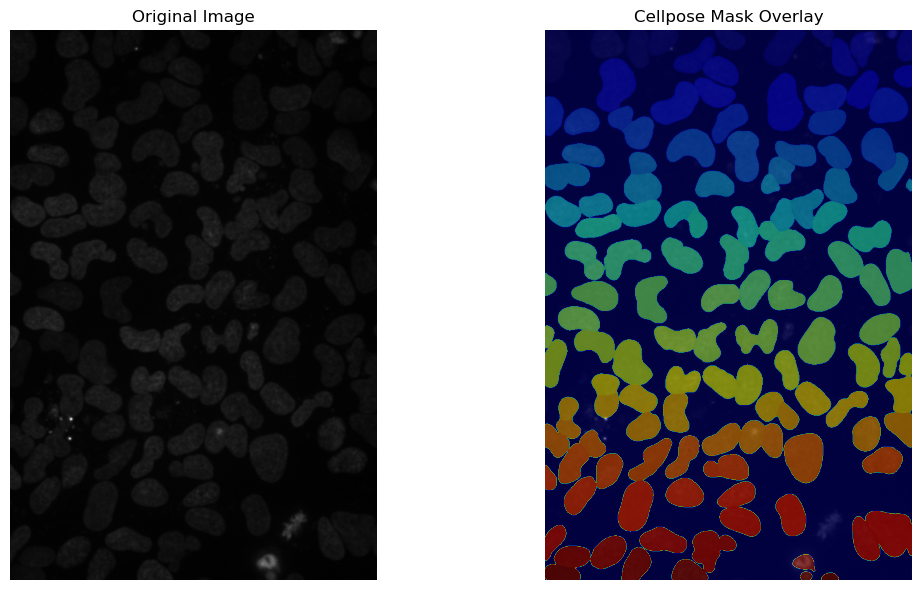

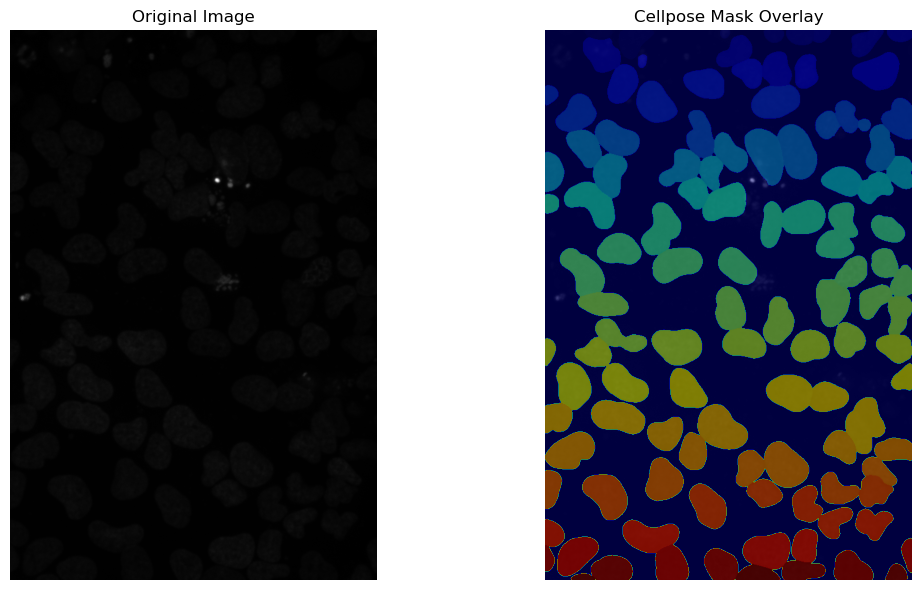

In [ ]:
import random
import os
import tifffile
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_samples(image_dir, mask_dir, num_samples=5, seed=None):
    """
    Randomly selects and visualizes TIFF images with their corresponding Cellpose masks.
    
    Parameters:
      image_dir (str): Directory containing the original TIFF images (e.g., DAPI images used for mask generation).
      mask_dir (str): Directory containing the Cellpose mask TIFFs.
      num_samples (int): Number of random samples to visualize.
      seed (int, optional): Seed for reproducibility.
    """
    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    
    # Get list of TIFF files (exclude mask files)
    image_files = [f for f in os.listdir(image_dir) 
                   if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    
    if not image_files:
        print(f"No TIFF files found in {image_dir}.")
        return
    
    # Adjust number of samples if there are fewer files than requested
    num_samples = min(num_samples, len(image_files))
    samples = random.sample(image_files, num_samples)
    
    for img_file in samples:
        img_path = os.path.join(image_dir, img_file)
        mask_filename = os.path.splitext(img_file)[0] + "_mask.tiff"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        # Check if the corresponding mask file exists
        if not os.path.exists(mask_path):
            print(f"Mask file {mask_filename} does not exist. Skipping {img_file}.")
            continue
        
        try:
            img = tifffile.imread(img_path)
            mask = tifffile.imread(mask_path)
            
            # If the image has multiple channels, average them to get a grayscale representation
            if img.ndim == 3:
                img_display = img.mean(axis=0)
            else:
                img_display = img
            
            # Normalize the image for display purposes
            img_display = img_display.astype(np.float32)
            img_display -= img_display.min()
            if img_display.max() != 0:
                img_display /= img_display.max()
            
            plt.figure(figsize=(12, 6))
            
            # Display the original image
            plt.subplot(1, 2, 1)
            plt.imshow(img_display, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            # Display the mask overlay on the original image
            plt.subplot(1, 2, 2)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
            plt.title('Cellpose Mask Overlay')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing {img_file}: {e}")

# =============================================================================
# Example Usage
# =============================================================================
# Define the directories for DAPI images (used for mask generation) and the generated masks.
dapi_image_dir = r"A:\_Ongoing\20250221_ActRep_rename\Output\DAPI_TIFF"
mask_output_dir = r"A:\_Ongoing\20250221_ActRep_rename\Output\mask"

# Visualize random samples (e.g., 2 samples, with a seed for reproducibility)
visualize_random_samples(dapi_image_dir, mask_output_dir, num_samples=2, seed=4333)


# Summary the data from mask, GFP and DeRed

In [2]:
import os
import re
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm

# =============================================================================
# Helper Function: Extract Group, Sample, and Repeat Information
# =============================================================================
def extract_info_from_filename(filename):
    """
    Extracts group (Act/Rep), sample, and repeat information from the filename.
    It first removes any time suffix (e.g., _t0) if present.
    
    Expected filename formats include:
      - 'Act_01_002.nd2' or 'Act_01_002.tiff'
      - 'Rep_A1_001.nd2' or 'Rep_A1_001.tiff'
      
    Returns:
      A tuple: (Group, Sample, Repeat), or ('Unknown', 'Unknown', 'Unknown') if not matched.
    """
    base = re.sub(r'_t\d+', '', os.path.splitext(filename)[0])
    pattern = re.compile(r'^(Act|Rep)_([A-Za-z0-9]+)_(\d{3})', re.IGNORECASE)
    m = pattern.search(base)
    if m:
        return m.group(1), m.group(2), m.group(3)
    else:
        return 'Unknown', 'Unknown', 'Unknown'

# =============================================================================
# Runnable Step 3: Intensity Calculation and Excel Output with Background Correction
# =============================================================================
def create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel):
    """
    Processes DsRed TIFF files (with corresponding GFP and mask files) to calculate cell-level intensities.
    For each cell (as determined by the DAPI mask), the average intensities in the GFP and DsRed channels are computed.
    
    In addition, the background intensity (calculated from areas not covered by any mask) is computed
    for both channels and recorded as 'DsRed_background' and 'GFP_background'. Then, the net mean intensity
    for each cell is computed as the difference between the cell's mean intensity and the background.
    
    The file name is parsed to extract Group, Sample, and Repeat information.
    
    Parameters:
      dsred_tiff_dir (str): Directory containing DsRed TIFF images.
      gfp_tiff_dir (str): Directory containing GFP TIFF images (with matching filenames).
      mask_dir (str): Directory containing the DAPI-generated mask TIFFs (named as <base>_mask.tiff).
      output_excel (str): Path to the output Excel file.
    """
    # List DsRed TIFF files (exclude any mask files)
    dsred_files = [f for f in os.listdir(dsred_tiff_dir)
                   if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    
    if not dsred_files:
        print("No DsRed TIFF files found in", dsred_tiff_dir)
        return
    
    data = []
    
    # Process each DsRed TIFF file
    for tiff_file in tqdm(dsred_files, desc="Processing TIFF files"):
        # Construct full paths for DsRed, GFP, and mask files
        dsred_path = os.path.join(dsred_tiff_dir, tiff_file)
        gfp_path   = os.path.join(gfp_tiff_dir, tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path  = os.path.join(mask_dir, mask_filename)
        
        # Check that corresponding GFP and mask files exist
        if not os.path.exists(gfp_path):
            print(f"GFP file not found for {tiff_file}, skipping.")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask file not found for {tiff_file}, skipping.")
            continue
        
        # Read images
        try:
            dsred_img = tifffile.imread(dsred_path)
            gfp_img   = tifffile.imread(gfp_path)
            mask_img  = tifffile.imread(mask_path)
        except Exception as e:
            print(f"Error reading files for {tiff_file}: {e}")
            continue
        
        # Compute background intensities from areas outside any cell (mask == 0)
        background_mask = (mask_img == 0)
        if np.any(background_mask):
            dsred_background = np.mean(dsred_img[background_mask])
            gfp_background   = np.mean(gfp_img[background_mask])
        else:
            dsred_background = np.nan
            gfp_background   = np.nan
        
        # Identify unique cell labels (ignore background, assumed to be 0)
        cell_indices = np.unique(mask_img)
        cell_indices = cell_indices[cell_indices != 0]
        
        # Compute average intensities for each cell, record background, and calculate net mean values
        for cell in cell_indices:
            cell_mask = (mask_img == cell)
            avg_gfp   = np.mean(gfp_img[cell_mask])
            avg_dsred = np.mean(dsred_img[cell_mask])
            
            # Compute net mean as the difference between cell's mean intensity and background intensity
            gfp_net_mean   = avg_gfp - gfp_background if not np.isnan(gfp_background) else np.nan
            dsred_net_mean = avg_dsred - dsred_background if not np.isnan(dsred_background) else np.nan
            
            record = {
                "File Name": tiff_file,
                "Mask Index": cell,
                "Average GFP Intensity": avg_gfp,
                "Average DsRed Intensity": avg_dsred,
                "GFP_background": gfp_background,
                "DsRed_background": dsred_background,
                "GFP_net_mean": gfp_net_mean,
                "DsRed_net_mean": dsred_net_mean
            }
            data.append(record)
    
    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    
    # Extract metadata (Group, Sample, Repeat) from the file name
    df[['Group', 'Sample', 'Repeat']] = df['File Name'].apply(lambda x: pd.Series(extract_info_from_filename(x)))
    
    # Drop the original file name column
    df = df.drop(columns=["File Name"])
    
    # Rename intensity columns for clarity
    df = df.rename(columns={
        "Average GFP Intensity": "GFP_Mean",
        "Average DsRed Intensity": "DsRed_Mean"
    })
    
    # Arrange columns in desired order
    df = df[['Group', 'Sample', 'Repeat', 'Mask Index', 
             "GFP_Mean", "DsRed_Mean", "GFP_background", "DsRed_background", 
             "GFP_net_mean", "DsRed_net_mean"]]
    
    # Write DataFrame to an Excel file
    df.to_excel(output_excel, index=False)
    print("Excel summary saved to:", output_excel)

# ----- Example Usage -----
# Adjust these paths as needed for your data.
dsred_tiff_dir = r"A:\_Ongoing\20250221_ActRep_rename\Output\DsRed_TIFF"
gfp_tiff_dir   = r"A:\_Ongoing\20250221_ActRep_rename\Output\GFP_TIFF"
mask_dir       = r"A:\_Ongoing\20250221_ActRep_rename\Output\mask"
output_excel   = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary.xlsx"

create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel)


Processing TIFF files: 100%|██████████| 4800/4800 [01:32<00:00, 51.75it/s] 


Excel summary saved to: A:\_Ongoing\20250221_ActRep_rename\Output\summary.xlsx


# Re-name the Sample name

In [3]:
import os
import pandas as pd

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous analysis step (summary of intensities)
input_excel = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary.xlsx"

# Output Excel file with the updated sample names (reporter expression with renamed samples)
output_excel_renamed = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary_renamed.xlsx"

# -----------------------------
# SAMPLE MAPPING DICTIONARY
# -----------------------------
# Modify this dictionary for different sample organizations in the future.
sample_mapping = {
    "A1": "Tile 1",
    "A2": "Tile 2",
    "A3": "Tile 3",
    "A4": "Tile 4",
    "A5": "Tile 5",
    "A6": "Tile 6",
    "B1": "Tile 7",
    "B2": "Tile 8",
    "B3": "Tile 9",
    "B4": "Tile 10",
    "B5": "Tile 11",
    "B6": "Tile 12",
    "C1": "Tile 13",
    "C2": "Tile 14",
    "C3": "LAP*IDR",
    "C4": "LAPIDR",
    "C5": "LIPIDR",
    "C6": "FL",
    "D1": "optLAP*IDR",
    "D2": "Halo_NLS",
    "D3": "AR_RUNX2",
    "D4": "Tile1woNLS",
    "D5": "RUNX2CTD",
    "D6": "VP16"
}

# -----------------------------
# READ INPUT DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# APPLY SAMPLE MAPPING
# -----------------------------
# Create a new column "Sample_name" by mapping the "Sample" column
# If a sample code is not found in the dictionary, its name will be NaN.
df["Sample_name"] = df["Sample"].map(sample_mapping)

# -----------------------------
# SAVE THE UPDATED DATAFRAME
# -----------------------------
# Rearranging columns if desired (e.g., putting "Sample_name" next to "Sample")
# Here, we assume the DataFrame already has columns such as:
# Group, Sample, Repeat, Mask Index, GFP_Mean, DsRed_Mean, GFP_background, DsRed_background, GFP_net_mean, DsRed_net_mean
# We'll simply place "Sample_name" after "Sample" for clarity.
cols = df.columns.tolist()
if "Sample" in cols and "Sample_name" in cols:
    # Remove the sample name column and reinsert it after "Sample"
    cols.remove("Sample_name")
    sample_index = cols.index("Sample") + 1
    cols.insert(sample_index, "Sample_name")
    df = df[cols]

# Write the updated DataFrame to a new Excel file
df.to_excel(output_excel_renamed, index=False)
print("Renamed summary Excel file saved to:", output_excel_renamed)


Renamed summary Excel file saved to: A:\_Ongoing\20250221_ActRep_rename\Output\summary_renamed.xlsx


# filter out the false negative cells with less than "10" net DsRed value

In [10]:
import os
import pandas as pd

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous renaming step (contains "Sample" and "Sample_name")
input_excel = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary_renamed.xlsx"

# Output Excel file for filtered data
output_excel_filtered = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary_filtered_renamed.xlsx"

# Define the cutoff value for DsRed_net_mean.
# Any cell with a DsRed_net_mean below this value will be removed.
cutoff_value = 10  # Adjust this value as needed

# -----------------------------
# READ INPUT DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# FILTER DATA
# -----------------------------
# Filter out rows where DsRed_net_mean is less than the cutoff value.
df_filtered = df[df["DsRed_net_mean"] >= cutoff_value].copy()

# Save the filtered DataFrame to an Excel file.
df_filtered.to_excel(output_excel_filtered, index=False)
print("Filtered summary Excel file saved to:", output_excel_filtered)

# -----------------------------
# COUNT AND PRINT DATA POINTS PER SAMPLE, SEPARATED BY GROUP
# -----------------------------
# Define the desired order of sample codes from A1 to D6.
sample_order = [
    "A1", "A2", "A3", "A4", "A5", "A6",
    "B1", "B2", "B3", "B4", "B5", "B6",
    "C1", "C2", "C3", "C4", "C5", "C6",
    "D1", "D2", "D3", "D4", "D5", "D6"
]

# Get unique groups (e.g. Act and Rep) from the data
groups = sorted(df["Group"].dropna().unique())

print("\nSummary of filtering by DsRed_net_mean cutoff (separated by group):")
for group in groups:
    print(f"\nGroup: {group}")
    for code in sample_order:
        # Filter by group and sample code
        subset = df[(df["Group"] == group) & (df["Sample"] == code)]
        total = subset.shape[0]
        passed = df_filtered[(df_filtered["Group"] == group) & (df_filtered["Sample"] == code)].shape[0]
        failed = total - passed
        # Retrieve descriptive sample name (if available)
        sample_name_arr = df.loc[(df["Group"] == group) & (df["Sample"] == code), "Sample_name"].unique()
        sample_name = sample_name_arr[0] if len(sample_name_arr) > 0 else "Unknown"
        print(f"  Sample {code} ({sample_name}): Total = {total}, Passed = {passed}, Failed = {failed}")


Filtered summary Excel file saved to: A:\_Ongoing\20250221_ActRep_rename\Output\summary_filtered_renamed.xlsx

Summary of filtering by DsRed_net_mean cutoff (separated by group):

Group: Act
  Sample A1 (Tile 1): Total = 9507, Passed = 9263, Failed = 244
  Sample A2 (Tile 2): Total = 12368, Passed = 11075, Failed = 1293
  Sample A3 (Tile 3): Total = 11315, Passed = 11041, Failed = 274
  Sample A4 (Tile 4): Total = 13103, Passed = 12429, Failed = 674
  Sample A5 (Tile 5): Total = 12488, Passed = 11447, Failed = 1041
  Sample A6 (Tile 6): Total = 10594, Passed = 10091, Failed = 503
  Sample B1 (Tile 7): Total = 12604, Passed = 11799, Failed = 805
  Sample B2 (Tile 8): Total = 12186, Passed = 12079, Failed = 107
  Sample B3 (Tile 9): Total = 14505, Passed = 12980, Failed = 1525
  Sample B4 (Tile 10): Total = 13594, Passed = 13110, Failed = 484
  Sample B5 (Tile 11): Total = 11384, Passed = 10776, Failed = 608
  Sample B6 (Tile 12): Total = 9664, Passed = 5210, Failed = 4454
  Sample C1 (T

# Plot the intensity

great, now I want to plot the data from our lastest excel. Act and Rep have their own plot.
 Creates a horizontal violin plot, The y-axis will display the sample names (descriptive names from the 'Sample_name' column)  in reversed order (i.e. the lowest sample code at the top). X-axis will be the GFP net mean intensity.

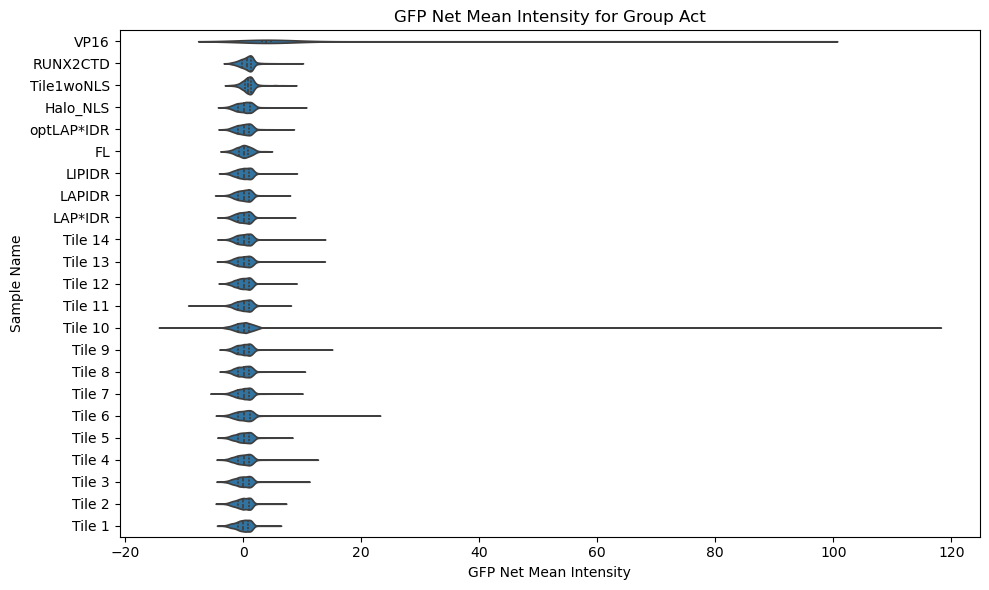

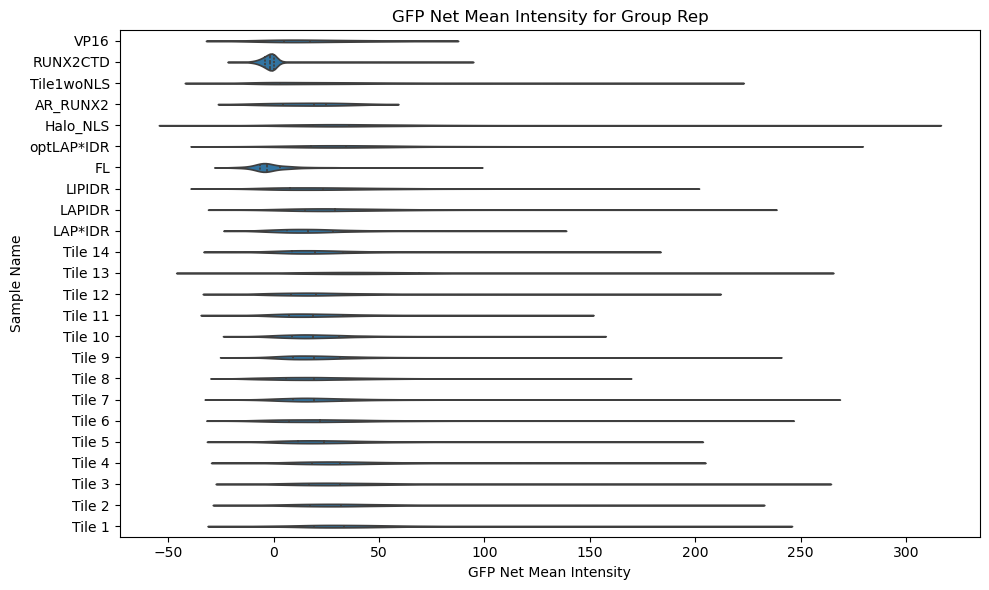

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous filtering and renaming step
input_excel = r"A:\_Ongoing\20250221_ActRep_rename\Output\summary_filtered_renamed.xlsx"

# Define the desired order of sample codes from A1 to D6
sample_order = [
    "A1", "A2", "A3", "A4", "A5", "A6",
    "B1", "B2", "B3", "B4", "B5", "B6",
    "C1", "C2", "C3", "C4", "C5", "C6",
    "D1", "D2", "D3", "D4", "D5", "D6"
]

# Create a dictionary mapping each sample code to its order index for sorting purposes.
order_dict = {code: i for i, code in enumerate(sample_order)}

# -----------------------------
# READ DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# PLOTTING FUNCTION
# -----------------------------
def plot_violin_for_group(df_group, group_name):
    """
    Create a horizontal violin plot for a given group.
    The y-axis displays descriptive sample names in reversed order (lowest sample code at the top),
    and the x-axis displays the GFP net mean intensity.
    """
    # Get unique sample codes present in this group and sort them by our defined order.
    unique_codes = df_group["Sample"].unique().tolist()
    unique_codes_sorted = sorted(unique_codes, key=lambda x: order_dict.get(x, 999))
    # Reverse the order so that the lowest sample code appears at the top.
    unique_codes_sorted_reversed = list(reversed(unique_codes_sorted))
    
    # Now, derive the corresponding descriptive sample names in that reversed order.
    order_sample_names = []
    for code in unique_codes_sorted_reversed:
        # Assuming all rows for a given code have the same Sample_name:
        sample_name = df_group.loc[df_group["Sample"] == code, "Sample_name"].iloc[0]
        order_sample_names.append(sample_name)
    
    # Create the horizontal violin plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=df_group,
        x="GFP_net_mean",
        y="Sample_name",
        order=order_sample_names,
        orient="h",
        inner="quartile"  # optionally show quartiles
    )
    plt.title(f"GFP Net Mean Intensity for Group {group_name}")
    plt.xlabel("GFP Net Mean Intensity")
    plt.ylabel("Sample Name")
    plt.tight_layout()
    plt.show()

# -----------------------------
# SEPARATE DATA BY GROUP AND PLOT
# -----------------------------
groups = df["Group"].dropna().unique()

for group in groups:
    df_group = df[df["Group"] == group].copy()
    plot_violin_for_group(df_group, group)


# analyze the ratio of expression

# Plot